25.04.2022

# Compute and visualize metrics from .json files

Load results stored in .json files located in folders `training_validation\<training name>\<metrics type>` where `metrics_type` can be **per_pixel_results** or **spark_peaks_results**. Each folder contain a dict for each class.

In per_pixel_results, dicts have keys `[t/argmax][min radius][exclusion radius][result type]`.

In spark_peaks_results, dicts have keys `[t/argmax][min radius][result type]`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import imageio
from collections import defaultdict
import pprint
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
import seaborn as sns

from metrics_tools import compute_f_score

In [3]:
import dataframe_image as dfi

In [4]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

## Set working directories

In [5]:
use_training_data = False
training_name = "peak_sparks_sum_losses_physio"
ignore_frames = 6 # first and last 6 frames not used for computing metrics

In [6]:
if not use_training_data:
    metrics_dir = os.path.join("trainings_validation", training_name)
else:
    metrics_dir = os.path.join("trainings_validation", "train_samples", training_name)
    

In [7]:
per_pixel_res_dir = os.path.join(metrics_dir, 'per_pixel_results')

spark_peaks_res_dir = os.path.join(metrics_dir, 'spark_peaks_results')

## Compute per pixel metrics

In [8]:
ys_classes = ['sparks', 'puffs', 'waves', 'sparks_puffs', 'puffs_waves', 'all']

In [9]:
per_pixel_rows = []
for event_class in ys_classes:
    # load saved dict and get rows for dataframe
    dict_filename = os.path.join(per_pixel_res_dir, event_class+"_results.json" )
    with open(dict_filename, 'r') as f:
        res = json.load(f) # movie_name x t x min_r x exclusion_r x video_id x metrics
        
        for movie_name, t_res in res.items():
            for t, min_r_res in t_res.items():
                for min_r, exclusion_r_res in min_r_res.items():
                    for exclusion_r, val in exclusion_r_res.items():
                        res[movie_name][t][min_r][exclusion_r]['iou'] = val['tp']/(val['tp']+val['fn']+val['fp']) if (val['tp']+val['fn']+val['fp']) != 0 else 1.0
                        res[movie_name][t][min_r][exclusion_r]['dice'] = val['tp']/(2*val['tp']+val['fn']+val['fp']) if (val['tp']+val['fn']+val['fp']) != 0 else 1.0
                        res[movie_name][t][min_r][exclusion_r]['prec'] = val['tp']/(val['tp']+val['fp']) if (val['tp']+val['fp']) != 0 else 1.0
                        res[movie_name][t][min_r][exclusion_r]['rec'] = val['tp']/(val['tp']+val['fn']) if (val['tp']+val['fn']) != 0 else 1.0
                        res[movie_name][t][min_r][exclusion_r]['accuracy'] = (val['tp']+val['tn'])/(val['tp']+val['tn']+val['fp']+val['fn'])
                        res[movie_name][t][min_r][exclusion_r]['mcc'] = (val['tp']*val['tn']-val['fp']*val['fn'])/np.sqrt(float((val['tp']+val['fp'])*(val['tp']+val['fn'])*(val['tn']+val['fp'])*(val['tn']+val['fn']))) if (val['tp']+val['fp'])*(val['tp']+val['fn'])*(val['tn']+val['fp'])*(val['tn']+val['fn']) != 0 else 0.0
                        
                        for metric_name, metric_val in val.items():
                            per_pixel_rows.append([event_class, movie_name, t, min_r, exclusion_r, metric_name, metric_val])
        
        

In [10]:
per_pixel_df = pd.DataFrame(per_pixel_rows, columns =['Event type', 'Movie name', 'Detection t', 'Min r', 'Exclusion r', 'Metric', 'Val'])

In [11]:
classes = per_pixel_df['Event type'].unique()
metrics = ['iou', 'dice', 'prec', 'rec', 'accuracy', 'mcc']

### 1) Heat maps of detection thresholds vs. min radius, with exclusion radius = 0

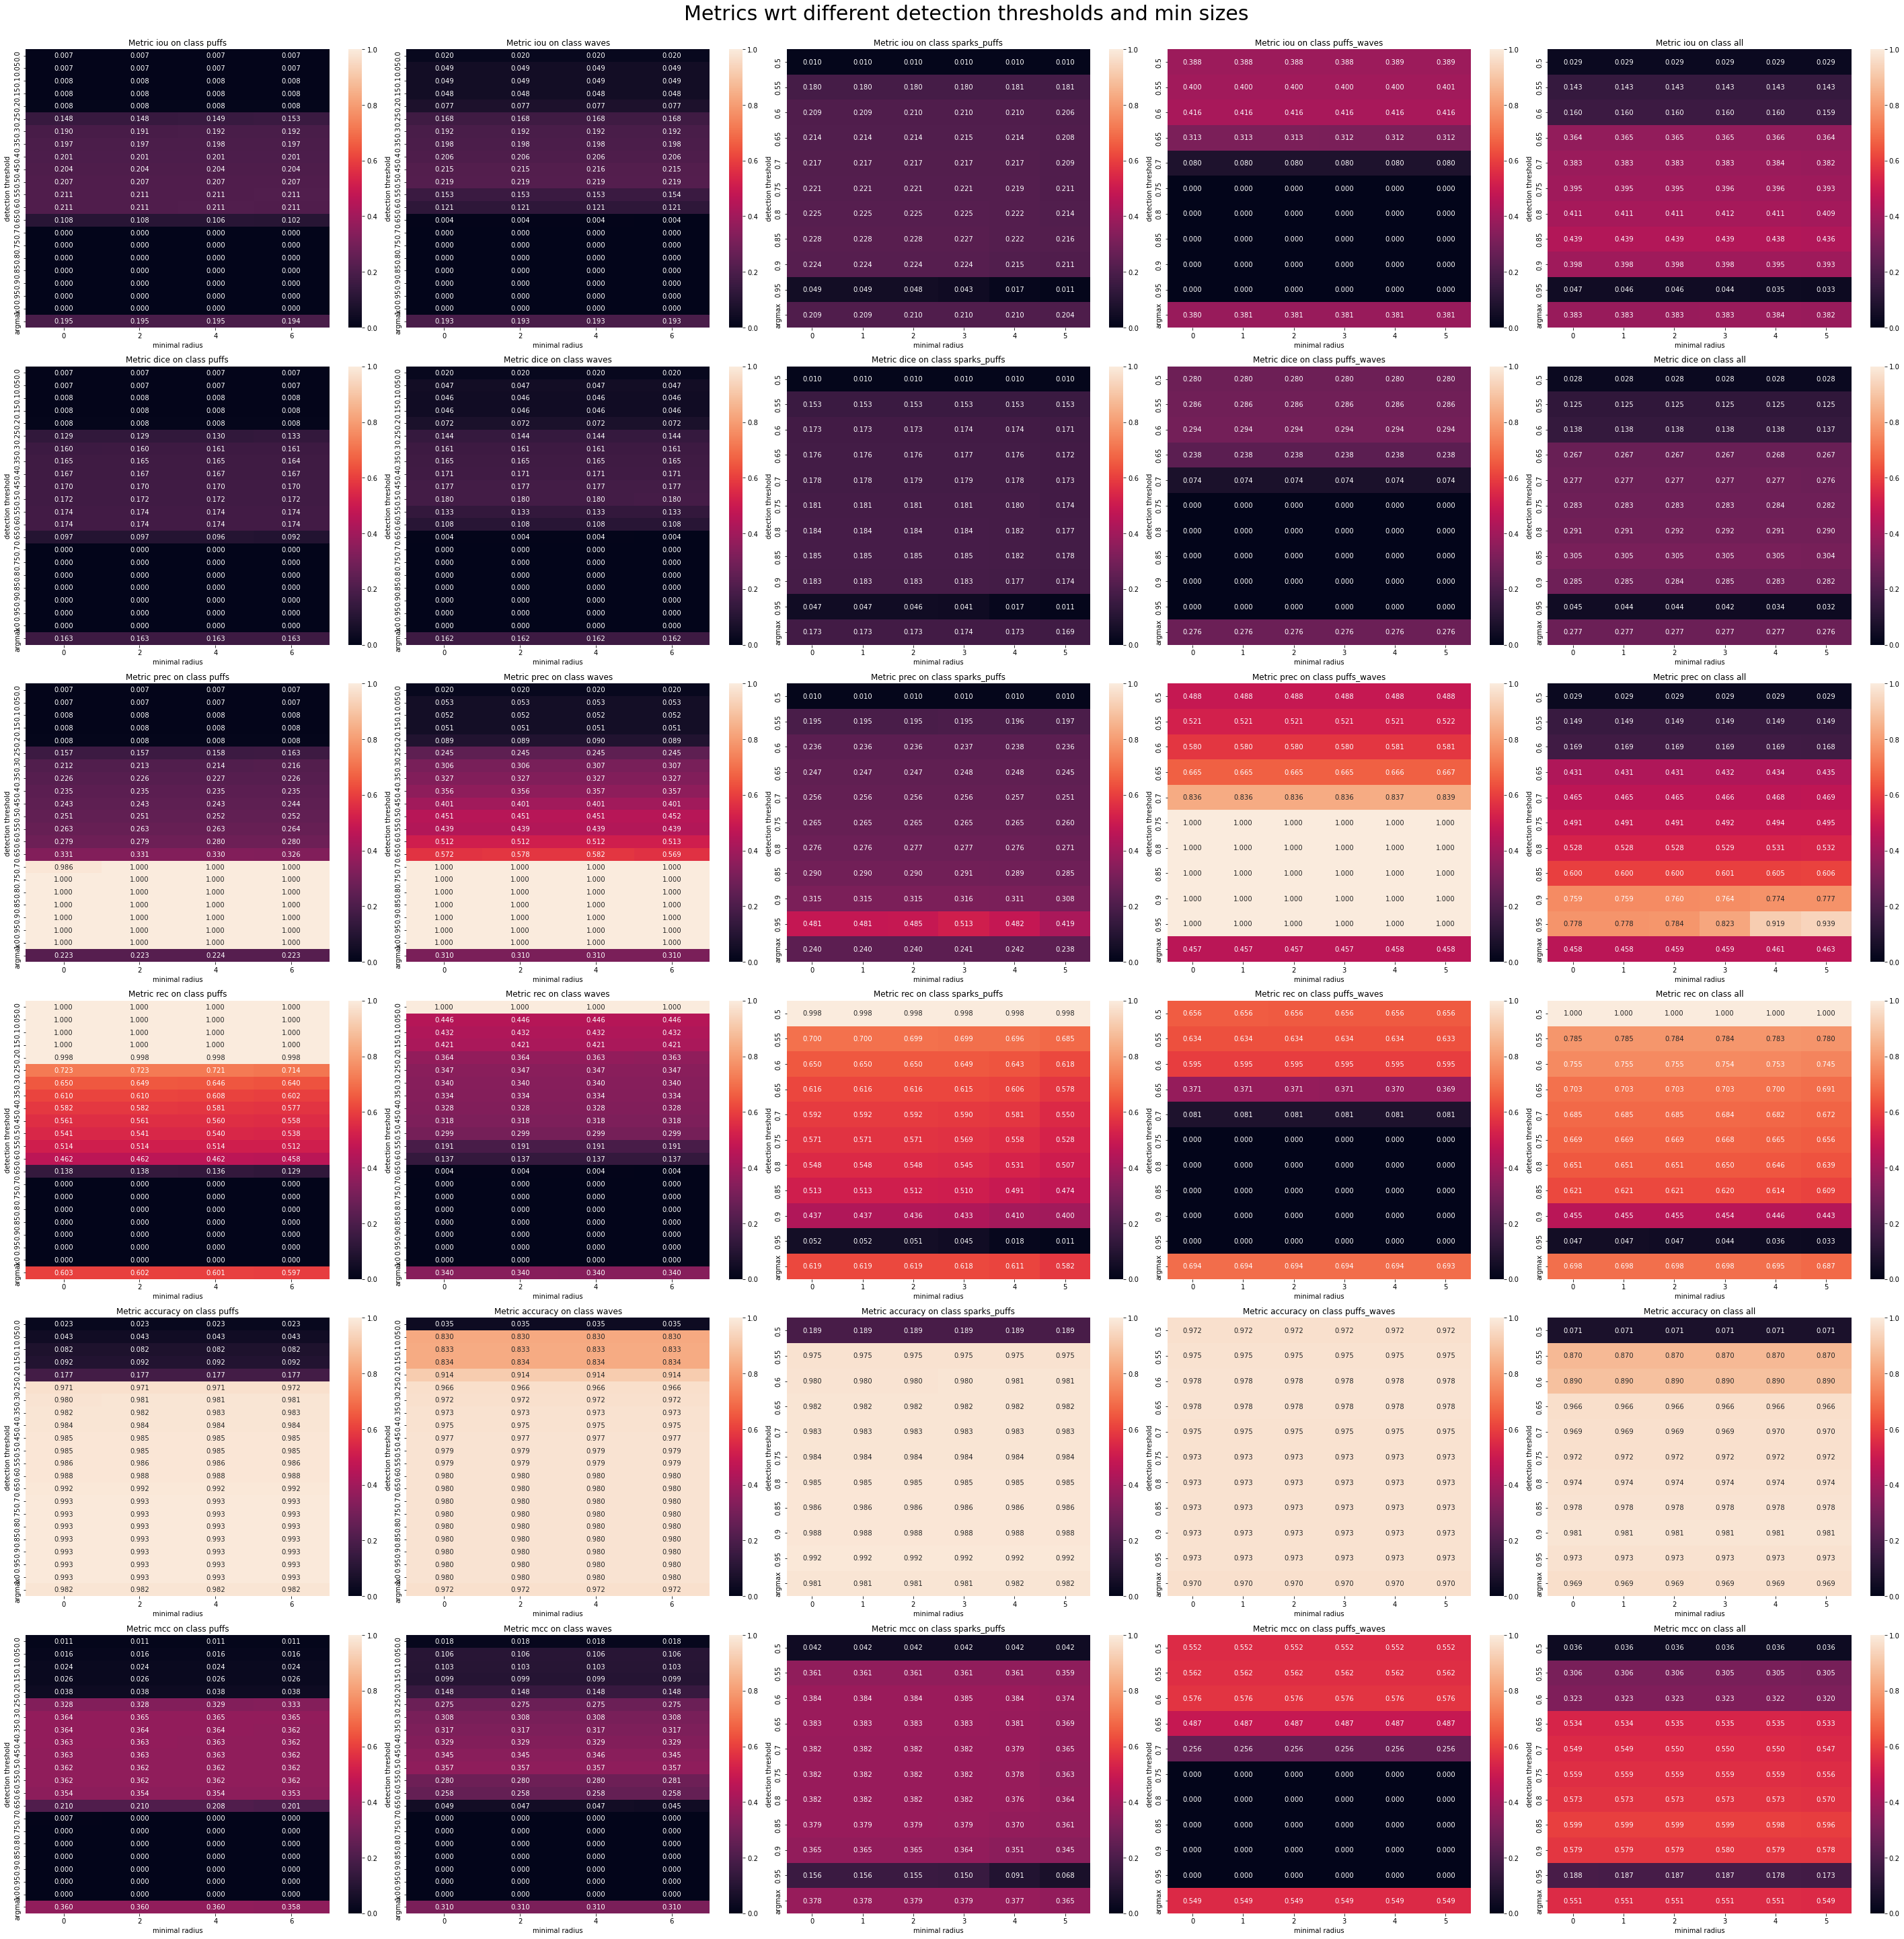

In [12]:
exclusion_r ='0'
movie_name = 'average'

# create plot for all classes and all metrics
fig, axs = plt.subplots(nrows=len(metrics), ncols=len(classes), figsize=(40, 40), squeeze = False)
plt.subplots_adjust(hspace=0.1, wspace=0.01, top=0.85)
fig.suptitle(f"Metrics wrt different detection thresholds and min sizes", fontsize=30, y=1)

                        
# loop through metrics, thresholds and axes
for i, metric_name in enumerate(metrics):
    for j, class_event in enumerate(classes):
        df_values = per_pixel_df[(per_pixel_df['Event type']==class_event) 
                         & (per_pixel_df['Movie name']==movie_name) 
                         & (per_pixel_df['Exclusion r']==exclusion_r) 
                         & (per_pixel_df['Metric']==metric_name)]
        # create pivot table, detection thresholds will be rows, min radius will be columns
        piv = pd.pivot_table(df_values, values="Val",columns=["Min r"], index=["Detection t"])
        
        #plot pivot table as heatmap using seaborn
        axs[i,j].set_title(f"Metric {metric_name} on class {class_event}")
        sns.heatmap(piv, annot=True, fmt='.3f', vmin=0, vmax=1, ax=axs[i,j])#, square=True)
        axs[i,j].set_ylabel("detection threshold")
        axs[i,j].set_xlabel("minimal radius")
        
        plt.setp(axs[i,j].yaxis.get_majorticklabels(), rotation=90) # rotate y labels
        plt.tight_layout()
        
        #ax.get_legend().remove()

plt.savefig(os.path.join(per_pixel_res_dir,"metrics_detection_t_vs_min_r.jpg"))

### 2) Heat maps of detection thresholds vs. exclusion radius, with min radius = 0

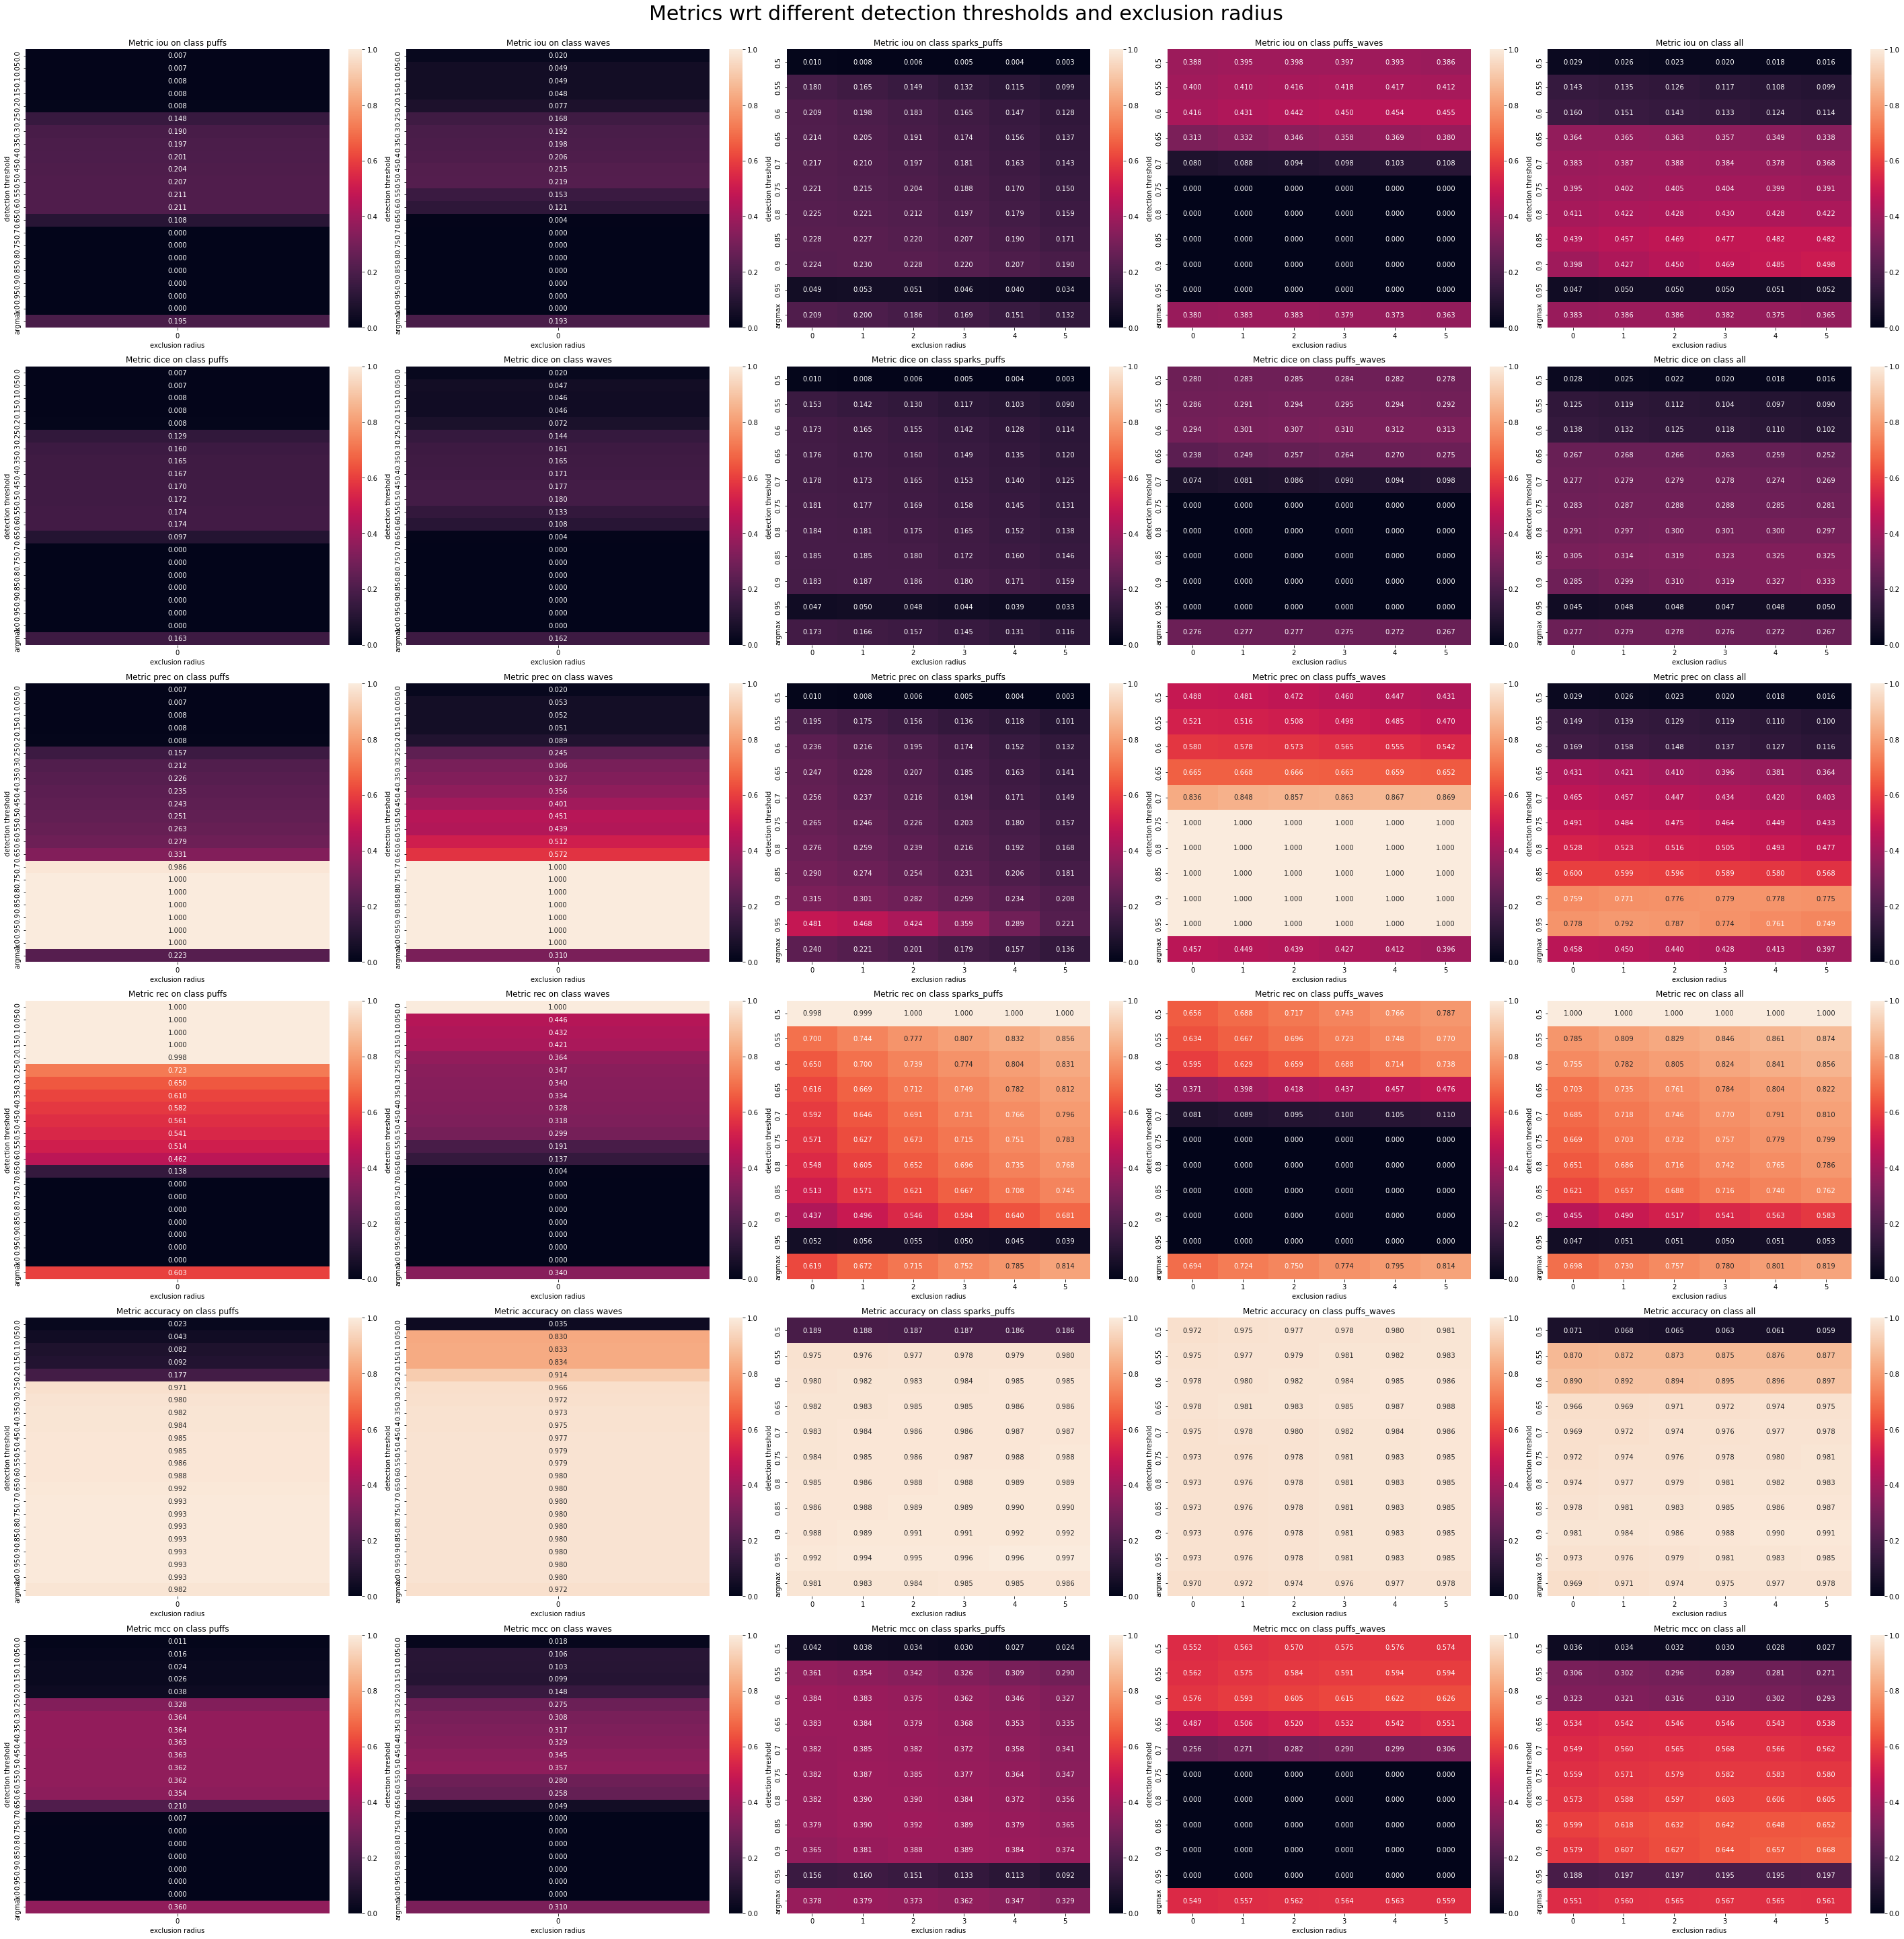

In [13]:
min_r ='0'
movie_name = 'average'

# create plot for all classes and all metrics
fig, axs = plt.subplots(nrows=len(metrics), ncols=len(classes), figsize=(40, 40), squeeze = False)
plt.subplots_adjust(hspace=0.1, wspace=0.01, top=0.85)
fig.suptitle(f"Metrics wrt different detection thresholds and exclusion radius", fontsize=30, y=1)

                        
# loop through metrics, thresholds and axes
for i, metric_name in enumerate(metrics):
    for j, class_event in enumerate(classes):
        df_values = per_pixel_df[(per_pixel_df['Event type']==class_event) 
                         & (per_pixel_df['Movie name']==movie_name) 
                         & (per_pixel_df['Min r']==min_r) 
                         & (per_pixel_df['Metric']==metric_name)]
        # create pivot table, detection thresholds will be rows, min radius will be columns
        piv = pd.pivot_table(df_values, values="Val",columns=["Exclusion r"], index=["Detection t"])
        
        #plot pivot table as heatmap using seaborn
        axs[i,j].set_title(f"Metric {metric_name} on class {class_event}")
        sns.heatmap(piv, annot=True, fmt='.3f', vmin=0, vmax=1, ax=axs[i,j])#, square=True)
        axs[i,j].set_ylabel("detection threshold")
        axs[i,j].set_xlabel("exclusion radius")
        
        plt.setp(axs[i,j].yaxis.get_majorticklabels(), rotation=90) # rotate y labels
        plt.tight_layout()
        
        #ax.get_legend().remove()

plt.savefig(os.path.join(per_pixel_res_dir,"metrics_detection_t_vs_exclusion_r.jpg"))

### 3) Tables with metrics val vs. detection threshold, with min radius = exclusion radius = 0

In [14]:
'''# Defining custom function which returns
# the list for df.style.apply() method
def highlight_max(s):
    #print(s.shape)
    #print(s.keys().isin(['prec','rec']))
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
        print(is_max)
    return ['background: lightgreen' if cell else '' for cell in is_max]''';

In [15]:
min_r = '0'
exclusion_r = '0'
movie_name = 'average'

with open(os.path.join(per_pixel_res_dir,"metrics_class_vs_detection_t.csv"), 'w') as f:

    for class_event in classes:
        df_values = per_pixel_df[(per_pixel_df['Event type']==class_event) 
                                 & (per_pixel_df['Movie name']==movie_name) 
                                 & (per_pixel_df['Min r']==min_r)
                                 & (per_pixel_df['Exclusion r']==exclusion_r)
                                 & (per_pixel_df['Metric'].isin(metrics))]

        # create pivot table, metrics will be rows, detection thresholds will be columns
        piv = pd.pivot_table(df_values, values="Val",columns=["Detection t"], index=["Metric"])

        display(piv.style.set_caption(f"Metrics for class {class_event}").highlight_max(color = 'darkgreen', axis = 1))
        dfi.export(piv.style.set_caption(f"Metrics for class {class_event}").highlight_max(color = 'lightgreen', axis = 1), 
                   os.path.join(per_pixel_res_dir, "table_"+class_event+"_vs_detection_t.png"))

        f.write(f"Metrics for class {class_event}")
        piv.to_csv(f)


Detection t,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,argmax
Metric,,,,,,,,,,,,,,,,,,,,,,
accuracy,0.022748,0.043394,0.081710,0.091971,0.176851,0.970655,0.980462,0.982479,0.983652,0.984558,0.985365,0.986396,0.987777,0.991932,0.992933,0.992932,0.992932,0.992932,0.992932,0.992932,0.992932,0.982368
dice,0.007129,0.007281,0.007580,0.007664,0.008426,0.129092,0.159892,0.164894,0.167466,0.169691,0.171600,0.174052,0.174141,0.097464,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162857
iou,0.007180,0.007334,0.007638,0.007723,0.008498,0.148227,0.190323,0.197453,0.201152,0.204370,0.207146,0.210730,0.210861,0.107989,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194538
mcc,0.010648,0.016380,0.023961,0.025698,0.037761,0.328363,0.364096,0.364424,0.363351,0.362982,0.362403,0.361673,0.353582,0.210245,0.006648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.359807
prec,0.007180,0.007334,0.007638,0.007723,0.008498,0.157172,0.212074,0.225992,0.235045,0.243234,0.251310,0.263187,0.279451,0.330625,0.986301,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.223176
rec,1.000000,1.000000,1.000000,1.000000,0.998241,0.722556,0.649823,0.609921,0.582459,0.561225,0.541020,0.513922,0.462102,0.138204,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.602555


Detection t,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,argmax
Metric,,,,,,,,,,,,,,,,,,,,,,
accuracy,0.035473,0.830283,0.832909,0.834018,0.914154,0.965889,0.971709,0.973217,0.974985,0.977086,0.978925,0.979154,0.980332,0.980230,0.980208,0.980208,0.980208,0.980208,0.980208,0.980208,0.980208,0.971942
dice,0.019711,0.047158,0.046398,0.045633,0.071806,0.143565,0.161117,0.165305,0.170726,0.177273,0.179641,0.133037,0.108177,0.004371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162054
iou,0.020108,0.049492,0.048656,0.047815,0.077361,0.167631,0.192061,0.198042,0.205874,0.215470,0.218978,0.153452,0.121299,0.004390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.193394
mcc,0.017935,0.106099,0.102512,0.099389,0.147969,0.274517,0.308256,0.316965,0.329029,0.345415,0.356724,0.280382,0.257950,0.048958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310161
prec,0.020108,0.052727,0.051984,0.051179,0.089472,0.244841,0.306408,0.327122,0.356465,0.400635,0.451059,0.438849,0.511767,0.572210,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.309727
rec,1.000000,0.446481,0.431764,0.421117,0.363673,0.347080,0.339785,0.334173,0.327653,0.317967,0.298537,0.190912,0.137173,0.004405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.339888


Detection t,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,argmax
Metric,,,,,,,,,,,
accuracy,0.188987,0.974527,0.980401,0.981930,0.982968,0.983893,0.984928,0.986089,0.987906,0.991975,0.981311
dice,0.009649,0.152524,0.173166,0.176337,0.178495,0.180780,0.183713,0.185346,0.182970,0.046789,0.173157
iou,0.009743,0.179974,0.209433,0.214088,0.217278,0.220674,0.225060,0.227516,0.223945,0.049085,0.209420
mcc,0.041842,0.360892,0.384157,0.382835,0.381780,0.381680,0.382422,0.379358,0.364909,0.155941,0.378437
prec,0.009743,0.195050,0.236096,0.247070,0.255619,0.264592,0.276433,0.290293,0.314918,0.480863,0.240340
rec,0.998473,0.699570,0.649676,0.615941,0.591601,0.570722,0.547722,0.512686,0.436692,0.051832,0.619458


Detection t,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,argmax
Metric,,,,,,,,,,,
accuracy,0.972244,0.974506,0.977552,0.978082,0.974896,0.973140,0.973140,0.973140,0.973140,0.973140,0.969637
dice,0.279751,0.285909,0.293713,0.238259,0.074184,0.000000,0.000000,0.000000,0.000000,0.000000,0.275623
iou,0.388410,0.400381,0.415856,0.312782,0.080128,0.000000,0.000000,0.000000,0.000000,0.000000,0.380497
mcc,0.551918,0.561665,0.575940,0.486961,0.256226,0.000000,0.000000,0.000000,0.000000,0.000000,0.548810
prec,0.487613,0.520897,0.580071,0.664649,0.835557,1.000000,1.000000,1.000000,1.000000,1.000000,0.457068
rec,0.656256,0.633773,0.594971,0.371394,0.081412,0.000000,0.000000,0.000000,0.000000,0.000000,0.694308


Detection t,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,argmax
Metric,,,,,,,,,,,
accuracy,0.070599,0.869671,0.889834,0.965919,0.969342,0.971533,0.974115,0.977950,0.980855,0.973154,0.968698
dice,0.028208,0.125325,0.137846,0.267027,0.276914,0.283183,0.291470,0.305055,0.284603,0.044546,0.276736
iou,0.029027,0.143282,0.159885,0.364307,0.382961,0.395055,0.411373,0.438963,0.397826,0.046622,0.382621
mcc,0.035753,0.305501,0.322942,0.534232,0.549414,0.559085,0.573086,0.598865,0.579302,0.187674,0.550796
prec,0.029027,0.149152,0.168654,0.430590,0.464895,0.490981,0.527699,0.599645,0.759326,0.778063,0.458430
rec,1.000000,0.784508,0.754605,0.702966,0.684834,0.669097,0.651098,0.620948,0.455227,0.047251,0.698230


### 4) Table with metrics val vs. class type, with min radius = exclusion radius = 0 and detection t = 'argmax'

In [16]:
min_r = '0'
exclusion_r = '0'
movie_name = 'average'
detection_t = 'argmax'

with open(os.path.join(per_pixel_res_dir,"argmax_metrics_vs_class_type.csv"), 'w') as f:

    
    df_values = per_pixel_df[(per_pixel_df['Movie name']==movie_name)
                             & (per_pixel_df['Detection t']==detection_t)
                             & (per_pixel_df['Min r']==min_r)
                             & (per_pixel_df['Exclusion r']==exclusion_r)
                             & (per_pixel_df['Metric'].isin(metrics))]

    # create pivot table, metrics will be rows, detection thresholds will be columns
    piv = pd.pivot_table(df_values, values="Val",columns=["Event type"], index=["Metric"])

    display(piv.style.set_caption(f"Metrics for each class using argmax detection").highlight_max(color = 'darkgreen', axis = 1))
    dfi.export(piv.style.set_caption(f"Metrics for each class using argmax detection").highlight_max(color = 'lightgreen', axis = 1), 
               os.path.join(per_pixel_res_dir, "table_argmax_metrics_vs_class_typ.png"))

    piv.to_csv(f)


Event type,all,puffs,puffs_waves,sparks_puffs,waves
Metric,,,,,
accuracy,0.968698,0.982368,0.969637,0.981311,0.971942
dice,0.276736,0.162857,0.275623,0.173157,0.162054
iou,0.382621,0.194538,0.380497,0.209420,0.193394
mcc,0.550796,0.359807,0.548810,0.378437,0.310161
prec,0.458430,0.223176,0.457068,0.240340,0.309727
rec,0.698230,0.602555,0.694308,0.619458,0.339888


## Compute spark peaks metrics

In [17]:
ys_classes = ['sparks']

In [18]:
spark_peaks_rows = []
for event_class in ys_classes:
    # load saved dict and get rows for dataframe
    dict_filename = os.path.join(spark_peaks_res_dir, event_class+"_results.json" )
    with open(dict_filename, 'r') as f:
        res = json.load(f) # movie_name x t x min_r x video_id x metrics
        
        for movie_name, t_res in res.items():
            for t, min_r_res in t_res.items():
                for min_r, val in min_r_res.items():
                    res[movie_name][t][min_r]['prec'] = val['tp']/(val['tp_fp']) if (val['tp_fp']) != 0 else 1.0
                    res[movie_name][t][min_r]['rec'] = val['tp']/(val['tp_fn']) if (val['tp_fn']) != 0 else 1.0
                    
                    betas = [0.5,1,2]
                    for beta in betas:
                        f_score = compute_f_score(res[movie_name][t][min_r]['prec'], 
                                                  res[movie_name][t][min_r]['rec'], 
                                                  beta)
                        res[movie_name][t][min_r][f"f{beta}_score"] = f_score

                    for metric_name, metric_val in val.items():
                        spark_peaks_rows.append([event_class, movie_name, t, min_r, metric_name, metric_val])

In [19]:
spark_peaks_df = pd.DataFrame(spark_peaks_rows, columns =['Event type', 'Movie name', 'Detection t', 'Min r', 'Metric', 'Val'])

In [20]:
classes = spark_peaks_df['Event type'].unique()
metrics = ['prec', 'rec'] + [f"f{beta}_score" for beta in [0.5,1,2]]

### 1) Heat maps of detection thresholds vs. min radius

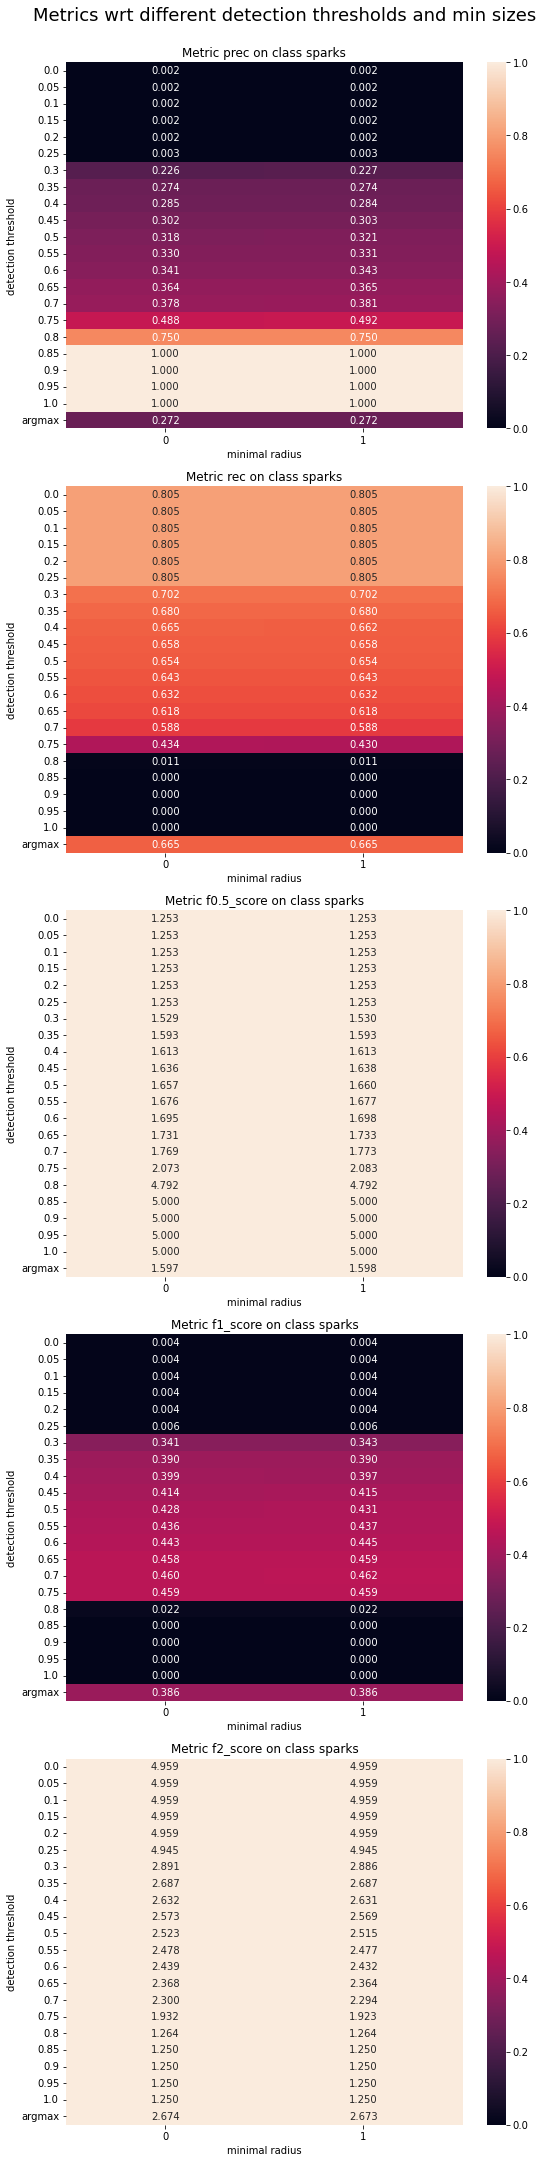

In [21]:
movie_name = 'average'

# create plot for all classes and all metrics
fig, axs = plt.subplots(nrows=len(metrics), ncols=len(classes), figsize=(8, 30), squeeze = False)
plt.subplots_adjust(hspace=0.1, wspace=0.01, top=0.85)
fig.suptitle(f"Metrics wrt different detection thresholds and min sizes", fontsize=18, y=1)

                        
# loop through metrics, thresholds and axes
for i, metric_name in enumerate(metrics):
    for j, class_event in enumerate(classes):
        df_values = spark_peaks_df[(spark_peaks_df['Event type']==class_event)
                         & (spark_peaks_df['Movie name']==movie_name)
                         & (spark_peaks_df['Metric']==metric_name)]
        # create pivot table, detection thresholds will be rows, min radius will be columns
        piv = pd.pivot_table(df_values, values="Val",columns=["Min r"], index=["Detection t"])
        
        #plot pivot table as heatmap using seaborn
        axs[i,j].set_title(f"Metric {metric_name} on class {class_event}")
        sns.heatmap(piv, annot=True, fmt='.3f', vmin=0, vmax=1, ax=axs[i,j])#, square=True)
        axs[i,j].set_ylabel("detection threshold")
        axs[i,j].set_xlabel("minimal radius")
        
        plt.setp(axs[i,j].yaxis.get_majorticklabels(), rotation=0) # rotate y labels
        plt.tight_layout()
        
        #ax.get_legend().remove()

plt.savefig(os.path.join(spark_peaks_res_dir,"metrics_detection_t_vs_min_r.jpg"))

### 2) Precision-recall curve for all min_radius

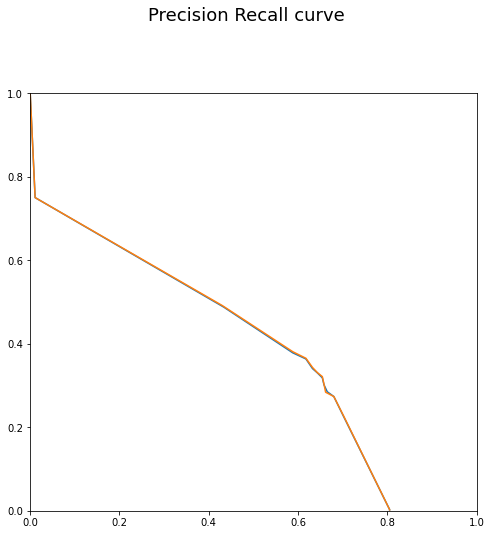

In [22]:
movie_name = 'average'
event_type = 'sparks'

# create plot for all classes and all metrics
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), squeeze = False)
plt.subplots_adjust(hspace=0.1, wspace=0.01, top=0.85)
fig.suptitle(f"Precision Recall curve", fontsize=18, y=1)

axs[0,0].set_ylim([0,1])
axs[0,0].set_xlim([0,1])

min_radius = spark_peaks_df['Min r'].unique()
                        
# loop through metrics, thresholds and axes
for min_r in min_radius:
    prec_df_values = spark_peaks_df[(spark_peaks_df['Event type']==class_event)
                               & (spark_peaks_df['Movie name']==movie_name)
                               & (spark_peaks_df['Min r']==min_r)
                               & (~spark_peaks_df['Detection t'].isin(['argmax']))
                               & (spark_peaks_df['Metric']=='prec')]
    
    rec_df_values = spark_peaks_df[(spark_peaks_df['Event type']==class_event)
                               & (spark_peaks_df['Movie name']==movie_name)
                               & (spark_peaks_df['Min r']==min_r)
                               & (~spark_peaks_df['Detection t'].isin(['argmax']))
                               & (spark_peaks_df['Metric']=='rec')]
    
    axs[0,0].plot(rec_df_values['Val'].values, prec_df_values['Val'].values, label=min_r)
    
    
    # create pivot table, detection thresholds will be rows, min radius will be columns
    #piv = pd.pivot_table(df_values, values="Val",columns=["Min r"], index=["Detection t"])

    #plot pivot table as heatmap using seaborn
    #axs[i,j].set_title(f"Metric {metric_name} on class {class_event}")
    #sns.heatmap(piv, annot=True, fmt='.3f', vmin=0, vmax=1, ax=axs[i,j])#, square=True)
    #axs[i,j].set_ylabel("detection threshold")
    #axs[i,j].set_xlabel("minimal radius")

    #plt.setp(axs[i,j].yaxis.get_majorticklabels(), rotation=0) # rotate y labels
    #plt.tight_layout()

    #ax.get_legend().remove()

#plt.savefig(os.path.join(spark_peaks_res_dir,"metrics_detection_t_vs_min_r.jpg"))

In [23]:
rec_df_values['Val'].values

array([0.80514706, 0.80514706, 0.80514706, 0.80514706, 0.80514706,
       0.80514706, 0.70220588, 0.68014706, 0.66176471, 0.65808824,
       0.65441176, 0.64338235, 0.63235294, 0.61764706, 0.58823529,
       0.43014706, 0.01102941, 0.        , 0.        , 0.        ,
       0.        ])